## 数据字典

TERMINALNO:用户id：用户唯一标志。
TIME:unix时间戳：从1970年1月1日（UTC/GMT的午夜）开始所经过的秒数，不考虑闰秒。min:2016/7/4 11:56:00;max:2016/12/31 23:41:00
TRIP_ID:行程id：用户行程唯一标志。
LONGITUDE:经度：用户行程目前所在经度。
LATITUDE:纬度：用户行程目前所在维度。
DIRECTION:方向(角度)：用户行程目前对应方向，正北为0，顺时针方向计算角度（如正东为90、正南为180），负值代表此时方向不可判断。
HEIGHT:海拔(m)：用户行程目前所处的海拔高度。
SPEED:速度(km/h)：用户行程目前的速度。
CALLSTATE:电话状态：用户行程目前的通话状态。（0,未知 1,呼出 2,呼入 3,连通 4,断连）
Y:客户赔付率：客户赔付情况，为本次建模的目标Y值。（test中不含此字段）

In [15]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import time
import warnings
warnings.filterwarnings("ignore")

istrain = 1
mn = 'gbr'
dfn = 'df_tfc1'
hci = 0.75
tci = 0.75
lci = 0.75
sci = 0.75

In [16]:
%xmode Plain
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
df = pd.read_csv("./demo.csv",dtype={'TERMINALNO':np.uint16,'TIME':np.uint32,'TRIP_ID':np.uint8,'LONGITUDE':np.float32,'LATITUDE':np.float32,'DIRECTION':np.int16,'HEIGHT':np.float32,'SPEED':np.float32,'CALLSTATE':np.uint8,'Y':np.float16})
df_base = df.groupby('TERMINALNO')['Y'].mean().reset_index()
df_base.head()

Exception reporting mode: Plain


,TERMINALNO,Y
0,1,0.00000
1,2,0.00000
2,3,0.00000
3,4,0.00000
4,5,0.00000


In [20]:
df['ftime'] = df['TIME'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(x)))
df['ftime'] = pd.to_datetime(df['ftime'])
df['hour'] = df['ftime'].dt.hour.astype(np.uint8)
df['minute'] = df['ftime'].dt.minute.astype(np.uint8)
df['weekday'] = df['ftime'].dt.weekday.astype(np.uint8)
df['day'] = df['ftime'].dt.day.astype(np.uint8)
df['month'] = df['ftime'].dt.month.astype(np.uint8)
# df['rs'] = np.rint(df['SPEED']/10).astype(np.uint8)
df = df[(df['month'] != 10) | ((df['month'] == 10) & (df['day'] > 9))]#排除国庆长假
df = df[(df['month'] != 9) | ((df['month'] == 9) & ((df['day'] > 18) | (df['day'] < 15)))]#排除中秋
# df[df['weekday']<5].groupby(['TERMINALNO'])['hour'].agg({'hcil':lambda x: stats.norm.interval(0.8,np.mean(x),np.std(x))[0]})
# float_types = ["float16", "float32", "float64"]
# for it in float_types:
#     print(np.finfo(it))

# int_types = ["uint8", "int16", "uint32"]
# for it in int_types:
#     print(np.iinfo(it))

In [19]:
# df[(df['month'] == 10) & (df['day'] < 9)].groupby(['TERMINALNO'])['Y'].mean().reset_index()
# t1.groupby(['TERMINALNO'])['cs3'].mean().reset_index()

## 计算极值、均值、标准差及置信区间

In [6]:
def stats1(df,df_base,col,pre,ci):
    l1 = pre + 'max'
    l2 = pre + 'min'
    l3 = pre + 'std'
    l4 = pre + 'mean'
    l5 = pre + 'cil'
    l6 = pre + 'cih'
    tn = df.groupby(['TERMINALNO'])[col].agg(
        {l1:np.max,l4:np.mean,l2:np.min,l3:np.std,
         l5:lambda x: stats.norm.interval(ci,np.mean(x),np.std(x))[0],
         l6:lambda x: stats.norm.interval(ci,np.mean(x),np.std(x))[1]}).reset_index()
    df_temp = pd.merge(df_base, tn, how='left', on=['TERMINALNO'])
    return df_temp
    

## 时间特征

In [24]:
def tfc1(df,df_base):#周一至周五出行时间stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    return stats1(t1,df_base,'hour',pre,tci)

def tfc2(df,df_base):#周六、日出行时间tats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    return stats1(t1,df_base,'hour',pre,tci)

def tfc3(df,df_base):#周一和周五出行时间stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'].isin([0,4]))]
    return stats1(t1,df_base,'hour',pre,tci)

def tfc4(df,df_base):#周一至周五出行时长stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    t1 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    return stats1(t1,df_base,'hour',pre,tci)

def tfc5(df,df_base):#周六、日出行时长stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    t1 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    return stats1(t1,df_base,'hour',pre,tci)

def tfc6(df,df_base):#周一和周五出行时长stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'].isin([0,4]))]
    t1 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    return stats1(t1,df_base,'hour',pre,tci)

def tfc7(df,df_base):#周一至周五出行频率stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    t1 = t1.groupby(['TERMINALNO','month','day','hour'])['minute'].count().reset_index()
    t1 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    return stats1(t1,df_base,'hour',pre,tci)

def tfc8(df,df_base):#周六、日出行频率stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    t1 = t1.groupby(['TERMINALNO','month','day','hour'])['minute'].count().reset_index()
    t1 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    return stats1(t1,df_base,'hour',pre,tci)

def tfc9(df,df_base):#上班高峰期（8，9，17,18）出行概率stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    t2 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = t1[(df['hour'].isin([8,9,17,18]))]
    t3 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = pd.merge(t2, t3, how='left', on=['TERMINALNO','month','day'])
    t1['ratio1'] = t1['hour_y']/t1['hour_x']
    return stats1(t1,df_base,'ratio1',pre,tci)

def tfc10(df,df_base):#凌晨（1，2,3,4）出行概率stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df
    t2 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = t1[(df['hour'].isin([1,2,3,4]))]
    t3 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = pd.merge(t2, t3, how='left', on=['TERMINALNO','month','day'])
    t1['ratio1'] = t1['hour_y']/t1['hour_x']
    return stats1(t1,df_base,'ratio1',pre,tci)

def tfc11(df,df_base):#晚餐后（20,21,22,23,0）出行概率stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df
    t2 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = t1[(df['hour'].isin([20,21,22,23,0]))]
    t3 = t1.groupby(['TERMINALNO','month','day'])['hour'].count().reset_index()
    t1 = pd.merge(t2, t3, how='left', on=['TERMINALNO','month','day'])
    t1['ratio1'] = t1['hour_y']/t1['hour_x']
    return stats1(t1,df_base,'ratio1',pre,tci)

## 海拔特征

In [26]:
def hfc1(df,df_base):#周一至周五出行海拔stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    return stats1(t1,df_base,'HEIGHT',pre,hci)

def hfc2(df,df_base):#周六、日出行海拔stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    return stats1(t1,df_base,'HEIGHT',pre,hci)

## 速度特征

In [30]:
def sfc1(df,df_base):#周一至周五出行速度stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    t1 = t1[(df['SPEED'] > 0)]
    return stats1(t1,df_base,'SPEED',pre,sci)

def sfc2(df,df_base):#周六、日出行速度stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    t1 = t1[(df['SPEED'] > 0)]
    return stats1(t1,df_base,'SPEED',pre,sci)

## 经纬度特征

In [57]:
def lfc1(df,df_base):#周一至周五出行区域stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] < 5)]
    t1 = t1.groupby(['TERMINALNO','month','day']).apply(
        lambda x: (stats.norm.interval(lci,np.mean(x['LONGITUDE']),np.std(x['LONGITUDE']))[1] -
        stats.norm.interval(lci,np.mean(x['LONGITUDE']),np.std(x['LONGITUDE']))[0]) * 
        (stats.norm.interval(lci,np.mean(x['LATITUDE']),np.std(x['LATITUDE']))[1] -
        stats.norm.interval(lci,np.mean(x['LATITUDE']),np.std(x['LATITUDE']))[0])).reset_index()
    t1.rename(columns={0:'area1'}, inplace = True)
    return stats1(t1,df_base,'area1',pre,lci)

def lfc2(df,df_base):#周六、日出行区域stats1值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['weekday'] >= 5)]
    t1 = t1.groupby(['TERMINALNO','month','day']).apply(
        lambda x: (stats.norm.interval(lci,np.mean(x['LONGITUDE']),np.std(x['LONGITUDE']))[1] -
        stats.norm.interval(lci,np.mean(x['LONGITUDE']),np.std(x['LONGITUDE']))[0]) * 
        (stats.norm.interval(lci,np.mean(x['LATITUDE']),np.std(x['LATITUDE']))[1] -
        stats.norm.interval(lci,np.mean(x['LATITUDE']),np.std(x['LATITUDE']))[0])).reset_index()
    t1.rename(columns={0:'area1'}, inplace = True)
    return stats1(t1,df_base,0,pre,lci)

## 电话状态

In [122]:
def cfc1(df,df_base):#根据样本数据状态不为4为筛选值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['CALLSTATE'] != 0)]
    t2 = t1.groupby(['TERMINALNO'])['CALLSTATE'].count().reset_index()
    t1 = df[(df['CALLSTATE'].isin([1,2,3]))]
    t3 = t1.groupby(['TERMINALNO'])['CALLSTATE'].count().reset_index()
    t1 = pd.merge(t2, t3, how='left', on=['TERMINALNO'])
    t1['cs1'] = t1['CALLSTATE_y']/t1['CALLSTATE_x']
    df_temp = pd.merge(df_base, t1.loc[:,['TERMINALNO','cs1']], how='left', on=['TERMINALNO'])
    return df_temp

def cfc2(df,df_base):#根据样本数据状态为3为筛选值
    pre = sys._getframe().f_code.co_name + '_'
    t1 = df[(df['CALLSTATE'] != 0)]
    t2 = t1.groupby(['TERMINALNO'])['CALLSTATE'].count().reset_index()
    t1 = df[(df['CALLSTATE'] == 3)]
    t3 = t1.groupby(['TERMINALNO'])['CALLSTATE'].count().reset_index()
    t1 = pd.merge(t2, t3, how='left', on=['TERMINALNO'])
    t1['cs2'] = t1['CALLSTATE_y']/t1['CALLSTATE_x']
    df_temp = pd.merge(df_base, t1.loc[:,['TERMINALNO','cs2']], how='left', on=['TERMINALNO'])
#     return stats1(t1,df_base,'cs2',pre,lci)
    return df_temp

In [123]:

cfc2(df,df_base).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
TERMINALNO    100 non-null uint64
Y             100 non-null float16
cs2           49 non-null float64
dtypes: float16(1), float64(1), uint64(1)
memory usage: 2.5 KB


## 按一周7天统计

In [ ]:
def d7cal(df,df_base,col,pre,ci):
    

## 按车主汇总统计

In [14]:
def cal_ratio(df,col,pre):
#     df = df_train
#     col = 'CALLSTATE'
#     pre = 'cs'
    df_temp1 = df[['TERMINALNO',col,'TRIP_ID']].groupby(['TERMINALNO',col]).count().reset_index()
    df_temp1.rename(columns={'TRIP_ID':'count1'}, inplace = True)
    df_temp2 = df[['TERMINALNO','TRIP_ID']].groupby(['TERMINALNO']).count().reset_index()
    df_temp2.rename(columns={'TRIP_ID':'count2'}, inplace = True)
    df_result = pd.merge(df_temp1, df_temp2, how='left', on=['TERMINALNO'])
    df_result['ratio'] = df_result['count1']/df_result['count2']
    df_temp1 = df_result[['TERMINALNO',col,'ratio']]
    df_temp2 = pd.get_dummies(df_temp1[col], prefix= pre)
    df_temp1 = pd.concat([df_temp1, df_temp2], axis=1)
    t = df_temp2.loc[:0,:].count(axis=1)
    startcol = df_temp2.columns.values[0]
    df_temp1.loc[:,startcol:] = df_temp1.loc[:,startcol:].mul(df_temp1['ratio'],axis=0)
    df_temp1 = df_temp1.groupby('TERMINALNO').sum().reset_index()
#     df_temp1 = df_temp1.groupby('TERMINALNO').sum().reset_index().drop([col,'ratio'], axis=1)
    return df_temp1

## 行车速度特征

In [7]:
# df_speed = df_train.groupby(['TERMINALNO'])['SPEED'].agg({'smax':np.max,'sstd':np.std,'smean':np.mean}).reset_index()
df_train[(df_train['hour'] < 12) & (df_train['weekday'] < 5)].head()

,TERMINALNO,TIME,TRIP_ID,LONGITUDE,LATITUDE,DIRECTION,HEIGHT,SPEED,CALLSTATE,Y,ftime,hour,weekday,day,month
0,1,1476923580,1,122.98517,41.10374,12,39.40259,2.15000,0,0.00000,2016-10-20 08:33:00,8,3,20,10
1,1,1476923640,1,122.98440,41.10490,24,39.31116,4.11000,0,0.00000,2016-10-20 08:34:00,8,3,20,10
2,1,1476923700,1,122.98650,41.10639,74,34.17896,2.99000,0,0.00000,2016-10-20 08:35:00,8,3,20,10
3,1,1476923760,1,122.98977,41.10688,115,37.76538,7.59000,0,0.00000,2016-10-20 08:36:00,8,3,20,10
4,1,1476923820,1,122.99109,41.10544,151,36.04919,0.24000,0,0.00000,2016-10-20 08:37:00,8,3,20,10


## 车主行车电话状态特征

In [8]:
df_cs = cal_ratio(df_train,'CALLSTATE','cs')
df_cs = df_cs.drop(['CALLSTATE','ratio'], axis=1)

## 车主行车时间特征

In [9]:
def hourms(df,pre): #按车主进行小时级别的统计计算:mean,std
    lable1 = pre + '_hmean'
    lable2 = pre + '_hstd'
    df_temp = df.groupby(['TERMINALNO']).agg({'hour':{lable1:'mean',lable2:'std'}})
    levels = df_temp.columns.levels
    labels = df_temp.columns.labels
    df_temp.columns = levels[1][labels[1]]
#     df_temp = df_am.reset_index()
    return df_temp
df_nam = hourms(df_train[(df_train['hour'] < 12) & (df_train['weekday'] < 5)],'nam').reset_index()
df_wam = hourms(df_train[(df_train['hour'] < 12) & (df_train['weekday'] >= 5)],'wam').reset_index()
df_npm = hourms(df_train[(df_train['hour'] >= 12) & (df_train['weekday'] < 5)],'npm').reset_index()
df_wpm = hourms(df_train[(df_train['hour'] >= 12) & (df_train['weekday'] >= 5)],'wpm').reset_index()


df_nhour = cal_ratio(df_train[df_train['weekday'] < 5],'hour','nth')
df_whour = cal_ratio(df_train[df_train['weekday'] >= 5],'hour','wth')
df_nhour = df_nhour.drop(['hour','ratio'], axis=1)
df_whour = df_whour.drop(['hour','ratio'], axis=1)
df_nhour['nhfreq'] = df_nhour.loc[:,'nth_0':][df_nhour>0].count(axis=1) #24小时出行分布
df_whour['whfreq'] = df_whour.loc[:,'wth_0':][df_whour>0].count(axis=1)

df_weekday = cal_ratio(df_train,'weekday','tw')
df_weekday = df_weekday.drop(['weekday','ratio'], axis=1)
df_month = cal_ratio(df_train,'month','tm')
df_month = df_month.drop(['month','ratio'], axis=1)

df_timespan = df_train.groupby(['TERMINALNO','month','day','hour']).agg({'SPEED':'count'}).reset_index()
df_timespan = df_timespan.groupby(['TERMINALNO','month','day']).agg({'hour':'count'}).reset_index()
df_timespan = df_timespan.groupby(['TERMINALNO','month']).agg({'day':'count','hour':'mean'}).reset_index()
df_timespan = df_timespan.groupby(['TERMINALNO']).agg({'day':'mean','hour':'mean'}).reset_index()
df_timespan.rename(columns={'day':'dayspm','hour':'hourspd'}, inplace = True)
# df_hour[['dayspm','hourspd']] = t[['day','hour']]
# df_whour

In [9]:
# df_hour['thc1'] = df_hour.loc[:,'th_00':'th_04'].sum(axis=1) #凌晨：0-4
# df_hour['thc2'] = df_hour.loc[:,['th_08','th_09','th_17','th_18']].sum(axis=1) #上下班高峰：8-9,17-18
# df_hour['thc3'] = df_hour['thc1'] + df_hour['thc2']
# df_hour['thc3'] = df_hour['thc3'].apply(lambda x: 1-x) #其他时间
# df_weekday['twc1'] = df_weekday.loc[:,['tw_0','tw_4']].sum(axis=1) #上下班高峰:周一，周五
# df_weekday['twc2'] = df_weekday.loc[:,['tw_5','tw_6']].sum(axis=1) #双休日
# df_weekday['twc3'] = df_weekday['twc1'] + df_weekday['twc2']
# df_weekday['twc3'] = df_weekday['twc3'].apply(lambda x: 1-x) #其他时间
#df_hour = df_hour.loc[:,['TERMINALNO','thc1','thc2','thc3']]
#df_weekday = df_weekday.loc[:,['TERMINALNO','twc1','twc2','twc3']]

In [10]:
df_main = pd.merge(df_owner, df_month, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_weekday, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_nam, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_wam, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_npm, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_wpm, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_nhour, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_whour, how='left', on=['TERMINALNO'])
df_main = pd.merge(df_main, df_timespan, how='left', on=['TERMINALNO'])
df_main = df_main.fillna(0)
df_main.head()

,TERMINALNO,Y,counts,tm_7,tm_8,tm_9,tm_10,tm_11,tm_12,tw_0,tw_1,tw_2,tw_3,tw_4,tw_5,tw_6,nam_hmean,nam_hstd,wam_hmean,wam_hstd,npm_hmean,npm_hstd,wpm_hmean,wpm_hstd,nth_0,nth_1,nth_2,nth_3,nth_4,nth_5,nth_6,nth_7,nth_8,nth_9,nth_10,nth_11,nth_12,nth_13,nth_14,nth_15,nth_16,nth_17,nth_18,nth_19,nth_20,nth_21,nth_22,nth_23,nhfreq,wth_0,wth_1,wth_2,wth_4,wth_5,wth_6,wth_7,wth_8,wth_9,wth_10,wth_11,wth_12,wth_13,wth_14,wth_15,wth_16,wth_17,wth_18,wth_19,wth_20,wth_21,wth_22,wth_23,whfreq,dayspm,hourspd
0,1,0.00000,294,0.00000,0.00000,0.00000,0.49660,0.00000,0.50340,0.02721,0.00000,0.00000,0.10204,0.72109,0.14966,0.00000,8.00000,0.00000,0.06818,0.25497,19.93750,2.88704,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04000,0.00000,0.00000,0.00000,0.00000,0.08000,0.00000,0.00000,0.03200,0.02800,0.18800,0.00000,0.10000,0.14400,0.22000,0.16800,9,0.93182,0.06818,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.50000,4.00000
1,2,0.00000,728,0.00000,0.00000,0.00000,0.00000,0.38324,0.61676,0.37088,0.00000,0.00962,0.39286,0.00000,0.03297,0.19368,1.47273,3.27139,11.00000,0.00000,14.86181,2.37185,15.99371,1.54468,0.16341,0.09947,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03020,0.09947,0.14565,0.13499,0.09236,0.08526,0.06039,0.01243,0.00000,0.07460,0.00178,0.00000,0.00000,12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03636,0.10909,0.00000,0.00000,0.00000,0.47879,0.32121,0.05455,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,4.00000,3.66667
2,3,0.00000,963,0.00000,0.79439,0.07373,0.00000,0.02908,0.10280,0.23053,0.09346,0.15472,0.06023,0.03115,0.18276,0.24714,7.70264,0.76762,8.57595,1.15632,18.87879,1.35371,17.32653,0.47135,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.31876,0.38798,0.02368,0.01821,0.01093,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13661,0.04554,0.04189,0.00000,0.00000,0.01639,9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13768,0.25362,0.23913,0.06039,0.07246,0.00000,0.00000,0.00000,0.00000,0.00000,0.15942,0.07729,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,5.50000,1.84896
3,4,0.00000,792,0.00000,0.00000,0.00000,0.00000,0.40404,0.59596,0.27399,0.18939,0.10985,0.00884,0.00000,0.22348,0.19444,9.76744,1.13667,9.90909,0.96220,18.34483,3.30006,18.31890,3.61003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04989,0.01518,0.09544,0.25380,0.14534,0.01085,0.03254,0.03471,0.05640,0.00000,0.03037,0.04121,0.05206,0.00000,0.06291,0.11931,0.00000,14,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03625,0.00906,0.12689,0.06042,0.08157,0.07553,0.04834,0.00000,0.00000,0.04532,0.06647,0.03927,0.05438,0.22356,0.13293,0.00000,13.00000,6.00000,4.25000
4,5,0.00000,903,0.00000,0.00000,0.00000,0.00000,0.21152,0.78848,0.08084,0.06977,0.21927,0.21816,0.19823,0.11960,0.09413,8.27064,1.22386,11.00000,0.00000,16.49390,2.15347,14.01333,2.12365,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10986,0.06620,0.09577,0.00845,0.02676,0.00000,0.01690,0.12817,0.12113,0.13239,0.09155,0.06479,0.02817,0.08451,0.02535,0.00000,0.00000,14,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22280,0.39378,0.00518,0.00000,0.07772,0.17617,0.12435,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,6.00000,3.50000


## 特征EDA

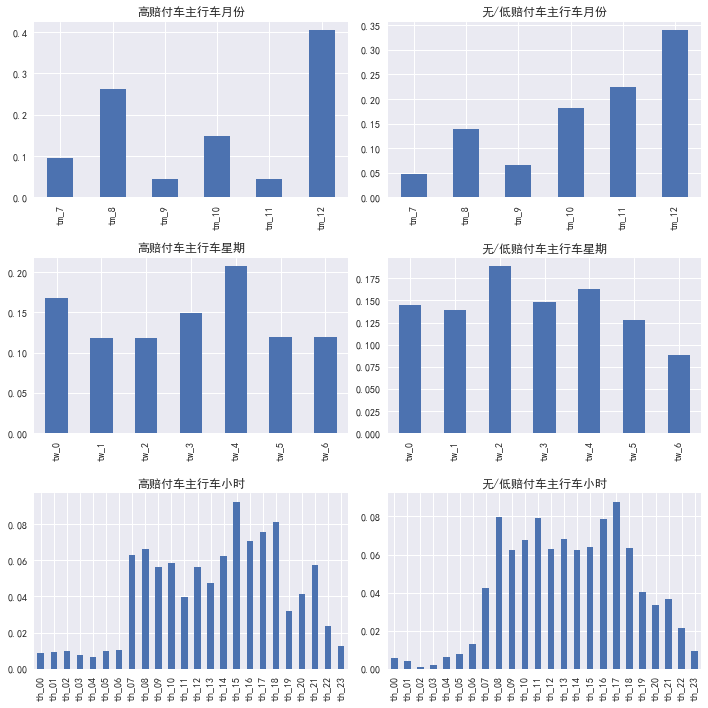

In [40]:
plt.rcParams['font.sans-serif']=['simhei']
fig = plt.figure()
plt.figure(figsize=(10,10)) 
fig.set(alpha=0.2)`
plt.subplot2grid((3,2),(0,0)) 
plt.title(u"高赔付车主行车月份")
df_main.loc[:,'tm_7':'tm_12'][df_main['Y'] > pay].mean().plot(kind='bar')
plt.subplot2grid((3,2),(0,1)) 
plt.title(u"无/低赔付车主行车月份")
df_main.loc[:,'tm_7':'tm_12'][df_main['Y'] <= pay].mean().plot(kind='bar')
plt.subplot2grid((3,2),(1,0)) 
plt.title(u"高赔付车主行车星期")
df_main.loc[:,'tw_0':'tw_6'][df_main['Y'] > pay].mean().plot(kind='bar')
# df_main.loc[:,'twc1':'twc3'][df_main['Y'] > pay].mean().plot(kind='bar')
plt.subplot2grid((3,2),(1,1)) 
plt.title(u"无/低赔付车主行车星期")
df_main.loc[:,'tw_0':'tw_6'][df_main['Y'] <= pay].mean().plot(kind='bar')
# df_main.loc[:,'twc1':'twc3'][df_main['Y'] <= pay].mean().plot(kind='bar')
plt.subplot2grid((3,2),(2,0)) 
plt.title(u"高赔付车主行车小时")
df_main.loc[:,'th_00':'th_23'][df_main['Y'] > pay].mean().plot(kind='bar')
# df_main.loc[:,'thc1':'thc3'][df_main['Y'] > pay].mean().plot(kind='bar')
plt.subplot2grid((3,2),(2,1)) 
plt.title(u"无/低赔付车主行车小时")
df_main.loc[:,'th_00':'th_23'][df_main['Y'] <= pay].mean().plot(kind='bar')
# df_main.loc[:,'thc1':'thc3'][df_main['Y'] <= pay].mean().plot(kind='bar')
plt.tight_layout()
plt.show()

df_train[['TERMINALNO','CALLSTATE','SPEED','Y']][df_train['Y']>0].groupby('TERMINALNO').describe()

## 行车高度特征

In [14]:
df_hight = df_train.groupby(['TERMINALNO'])['HEIGHT'].agg({'hstd':np.std,'hmean':np.mean}).reset_index()

## 行车高度特征EDA

In [57]:
df_main = pd.merge(df_owner, df_hight, how='left', on=['TERMINALNO'])
# df_main[df_main['HEIGHT'] > 100].sort_values(by = 'Y',axis = 0,ascending = False) 
df_main[df_main['Y'] < pay].sort_values(by = 'Y',axis = 0,ascending = False) 

,TERMINALNO,Y,counts,hmax,hmin,hvar,hmean
76,77,0.06958,735,187.65253,8.45944,760.20074,60.40656
73,74,0.05167,923,110.80634,12.99576,202.73903,56.01937
49,50,0.00000,1054,69.41467,-271.48862,181.11722,10.68716
74,75,0.00000,381,73.00000,3.00000,64.89591,8.54593
72,73,0.00000,814,402.89154,167.88306,803.20398,344.28534
71,72,0.00000,1423,9.80000,1.00000,1.69051,2.96058
70,71,0.00000,865,621.74561,252.83246,6413.93652,407.56769
68,69,0.00000,893,90.79236,-8.73212,169.45775,19.77107
67,68,0.00000,839,13.90000,2.80000,0.21648,5.49869
66,67,0.00000,637,35.26685,-31.01437,61.81528,6.48453


## 选择特征

In [11]:
# df_main = pd.merge(df_owner, df_hight, how='left', on=['TERMINALNO'])
# df_main = pd.merge(df_main, df_hight, how='left', on=['TERMINALNO'])
df_main.head()

,TERMINALNO,Y,counts,tm_7,tm_8,tm_9,tm_10,tm_11,tm_12,tw_0,tw_1,tw_2,tw_3,tw_4,tw_5,tw_6,nam_hmean,nam_hstd,wam_hmean,wam_hstd,npm_hmean,npm_hstd,wpm_hmean,wpm_hstd,nth_0,nth_1,nth_2,nth_3,nth_4,nth_5,nth_6,nth_7,nth_8,nth_9,nth_10,nth_11,nth_12,nth_13,nth_14,nth_15,nth_16,nth_17,nth_18,nth_19,nth_20,nth_21,nth_22,nth_23,nhfreq,wth_0,wth_1,wth_2,wth_4,wth_5,wth_6,wth_7,wth_8,wth_9,wth_10,wth_11,wth_12,wth_13,wth_14,wth_15,wth_16,wth_17,wth_18,wth_19,wth_20,wth_21,wth_22,wth_23,whfreq,dayspm,hourspd
0,1,0.00000,294,0.00000,0.00000,0.00000,0.49660,0.00000,0.50340,0.02721,0.00000,0.00000,0.10204,0.72109,0.14966,0.00000,8.00000,0.00000,0.06818,0.25497,19.93750,2.88704,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04000,0.00000,0.00000,0.00000,0.00000,0.08000,0.00000,0.00000,0.03200,0.02800,0.18800,0.00000,0.10000,0.14400,0.22000,0.16800,9,0.93182,0.06818,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.50000,4.00000
1,2,0.00000,728,0.00000,0.00000,0.00000,0.00000,0.38324,0.61676,0.37088,0.00000,0.00962,0.39286,0.00000,0.03297,0.19368,1.47273,3.27139,11.00000,0.00000,14.86181,2.37185,15.99371,1.54468,0.16341,0.09947,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03020,0.09947,0.14565,0.13499,0.09236,0.08526,0.06039,0.01243,0.00000,0.07460,0.00178,0.00000,0.00000,12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03636,0.10909,0.00000,0.00000,0.00000,0.47879,0.32121,0.05455,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,4.00000,3.66667
2,3,0.00000,963,0.00000,0.79439,0.07373,0.00000,0.02908,0.10280,0.23053,0.09346,0.15472,0.06023,0.03115,0.18276,0.24714,7.70264,0.76762,8.57595,1.15632,18.87879,1.35371,17.32653,0.47135,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.31876,0.38798,0.02368,0.01821,0.01093,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13661,0.04554,0.04189,0.00000,0.00000,0.01639,9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13768,0.25362,0.23913,0.06039,0.07246,0.00000,0.00000,0.00000,0.00000,0.00000,0.15942,0.07729,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,5.50000,1.84896
3,4,0.00000,792,0.00000,0.00000,0.00000,0.00000,0.40404,0.59596,0.27399,0.18939,0.10985,0.00884,0.00000,0.22348,0.19444,9.76744,1.13667,9.90909,0.96220,18.34483,3.30006,18.31890,3.61003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04989,0.01518,0.09544,0.25380,0.14534,0.01085,0.03254,0.03471,0.05640,0.00000,0.03037,0.04121,0.05206,0.00000,0.06291,0.11931,0.00000,14,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03625,0.00906,0.12689,0.06042,0.08157,0.07553,0.04834,0.00000,0.00000,0.04532,0.06647,0.03927,0.05438,0.22356,0.13293,0.00000,13.00000,6.00000,4.25000
4,5,0.00000,903,0.00000,0.00000,0.00000,0.00000,0.21152,0.78848,0.08084,0.06977,0.21927,0.21816,0.19823,0.11960,0.09413,8.27064,1.22386,11.00000,0.00000,16.49390,2.15347,14.01333,2.12365,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10986,0.06620,0.09577,0.00845,0.02676,0.00000,0.01690,0.12817,0.12113,0.13239,0.09155,0.06479,0.02817,0.08451,0.02535,0.00000,0.00000,14,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22280,0.39378,0.00518,0.00000,0.07772,0.17617,0.12435,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,6.00000,3.50000


## 训练

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import cross_val_predict

In [13]:
start_col = 'tm_7'
# X_train = StandardScaler().fit_transform(df_main.loc[:,start_col:])
X_train = df_main.loc[:,start_col:]
y_train = df_main['Y']

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
lr = LinearRegression()
# lr.fit(X_train,y_train)
# X_predict = lr.predict(X_train)
X_predict = cross_val_predict(lr, X_train, y_train, cv=10)

In [16]:
r2_score(y_train,X_predict)

-24.344027995905982

In [21]:
from sklearn.linear_model import SGDRegressor

In [25]:
sgdr = SGDRegressor()
sgdr.fit(X_train,y_train)
X_predict = sgdr.predict(X_train)

In [26]:
r2_score(y_train,X_predict)

-1.2718226577642202e+21

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

In [28]:
params = {'n_estimators': 500, 'max_depth': 4,'learning_rate': 0.01, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [29]:
X_predict = gbr.predict(X_train)
r2_score(y_train,X_predict)

0.99989888922425119

In [28]:
from sklearn import  feature_selection

In [31]:
fs = feature_selection.SelectPercentile(feature_selection.f_regression,percentile=20)

In [36]:
X_train_fs = fs.fit_transform(X_train,y_train)
gbr.fit(X_train_fs,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [37]:
gbr.predict(X_train_fs)

array([  3.44686045e-02,  -3.76590211e-02,   1.81821908e-02,
         1.91781453e-02,   1.99894467e-02,   2.64120832e-03,
         1.27430375e-02,   2.17501973e+00,  -2.86157561e-02,
        -7.61523755e-04,   1.26527053e-02,   2.95772215e-02,
         2.55422439e-02,   2.53211745e-02,  -2.08210272e-02,
         2.05469128e-03,   4.90158677e-02,   1.41168704e-02,
         8.83704020e-03,   2.46109741e-02,   2.28154390e-02,
         3.54858771e-02,  -7.61788675e-03,   1.50826548e+00,
        -1.65219460e-02,   3.21661783e-02,   3.65713072e-02,
        -1.39867320e-02,   7.06437847e-04,   1.43705195e-02,
         1.13935498e-01,   3.42490289e-02,   5.59280250e-04,
        -3.71323251e-03,   1.06108006e-02,   6.00317205e-03,
         2.72284865e-01,  -2.64082745e-02,   3.73274991e-01,
         1.41168704e-02,  -7.93686719e-03,   1.30536296e-01,
         6.64552775e-03,   4.52073404e-03,   3.67082393e-02,
         3.20247858e-02,   2.66611902e-02,   1.13886522e-02,
         1.22540550e-02,